In [83]:
import numpy as np
import pandas as pd
import itertools
from scipy.io import arff
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import threading
import operator
import collections
from scipy.spatial import distance
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
INPUT_DIR = "./Datasets/"

In [84]:
class ShapeletClassifier(BaseEstimator, ClassifierMixin):

    def fetchDistanceMeasure(self,dist_fn):
        # Map in the function of the distance metric
        if dist_fn == 'euclidean':
            return euclidean_distances
        elif dist_fn == 'manhattan':
            return manhattan_distances
        elif dist_fn == 'cosine':
            return distance.cosine
        else:
            return distance.euclidean
   
        
    def __init__(self, min_len=20, max_len=20, n_threads=2, shapelet_count=10, dist_fn = 'euclidean'):
        self.min_len = min_len
        self.max_len = max_len
        self.n_threads = n_threads
        self.k = 1
        self.dist_fn = self.fetchDistanceMeasure(dist_fn)
        self.shapelet_count = shapelet_count
        self.shapelet_dict = {}
        self.shapelet_dict1 = {}
        
        
#     def fit(self, X, y):
#         self.time_series = X
#         self.labels = y
#         candidates = self.generate_candidates()
#         split_candidates = np.array_split(candidates,self.n_threads)
#         threads = [threading.Thread(target=self.find_best_shapelet_worker, args=[pd.DataFrame(split_candidate),]) for split_candidate in split_candidates]
#         for thread in threads:
#             thread.start()
#         for thread in threads:
#             thread.join()
#         return self
    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        self.time_series = X
        self.classes = np.unique([label for label in y])
        for _class in self.classes:
            labels = []
            print(" Fetch Shapelets for ",_class)
            for label in y:
                if label == _class: labels.append(1)
                else: labels.append(0) 
            self.labels = pd.Series(labels)
            candidates = self.generate_candidates()
            split_candidates = np.array_split(candidates,self.n_threads)
            threads = [threading.Thread(target=self.find_best_shapelet_worker, args=[pd.DataFrame(split_candidate),]) for split_candidate in split_candidates]
            for thread in threads:
                thread.start()
            for thread in threads:
                thread.join()
            self.shapelet_dict1[_class] = self.shapelet_dict
            self.shapelet_dict = {}
        return self
    
    def visualise_shapelet(self):
        for _class in self.classes:
            count = 0
            print( "FOR CLASS ",_class )
            shapelet_dict = self.shapelet_dict1[_class]
            for ig in sorted(shapelet_dict,reverse=True)[:self.shapelet_count]:
                for shapelet in shapelet_dict[ig]:
                    if count > self.shapelet_count:
                        return
                    print("Shapelet:", shapelet)
                    #print("Distance:",shapelet_dict[shapelet][1])
                    print("Information Gain:",ig)
                    plt.plot(shapelet[0])
                    plt.show()
                    count += 1

    def predict(self, X, k=1, classifier="knn"):
        print(self.classes)
        # Check is fit had been called
        check_is_fitted(self, ['shapelet_dict1'])

        # Input validation
        X = check_array(X)
        # Output
        y = list()
        
        # Map in the function of the distance metric
        if classifier == 'dtree':
            for x in X:
                neighbours = {}
                i=0
                votes = {}
                for _class in self.classes:
                    shapelet_dict = self.shapelet_dict1[_class]
                    for ig in sorted(shapelet_dict,reverse=True)[:self.shapelet_count]:
                        for shapelet in shapelet_dict[ig]:
                            dist,idx = self.subsequence_distance(x, shapelet[0])
                            if (dist < shapelet[1]):
                                y.append(_class)
                            else:
                                y.append(2.0)
                            break       
                        break
                    break
        elif classifier == 'dtree1':
            for x in X:
                neighbours = {}
                i=0
                votes = {}
                for _class in self.classes:
                    shapelet_dict = self.shapelet_dict1[_class]
                    for ig in sorted(shapelet_dict,reverse=True)[:1]:
                        for shapelet in shapelet_dict[ig]:
                            dist,idx = self.subsequence_distance(x, shapelet[0])
                            if (dist < shapelet[1]):
                                y.append(_class)
                                break
                            else:
                                continue
                    break
        else:
            for x in X:
                neighbours = {}
                i=0
                votes = {}
                for _class in self.classes:
                    shapelet_dict = self.shapelet_dict1[_class]
                    for ig in sorted(shapelet_dict,reverse=True)[:self.shapelet_count]:
                        for shapelet in shapelet_dict[ig]:
                            dist,idx = self.subsequence_distance(x, shapelet[0])
                            if dist not in neighbours:
                                neighbours[dist] = _class
                for neighbour in sorted(neighbours):
                    if neighbours[neighbour] not in votes:
                        votes[neighbours[neighbour]] = 1
                    else:
                        votes[neighbours[neighbour]] += 1
                    i += 1
                    if i > k:
                        break
                y.append(max(votes.items(), key=operator.itemgetter(1))[0])    
        return y                
    
#     def search_label(self,time_serie, shapelet, split_point):
#         dist,idx = self.subsequence_distance(time_serie,shapelet)
#         if(idx < split_point):
#             search_label(time_serie[:idx],shapelet,split_point)
#         else:
#             search_label(time_serie[idx:],shapelet,split_point)
#     def predict(self, X):

#         # Check is fit had been called
#         check_is_fitted(self, ['shapelet_dict1'])

#         # Input validation
#         X = check_array(X)
#         # Output
#         y = list()
#         for x in X:
#             y_flag = False
#             for _class in self.classes:
#                 shapelet_dict = self.shapelet_dict1[_class]
#                 for shapelet in sorted(shapelet_dict,reverse=True)[:self.shapelet_count]:
#                     dist,idx = self.subsequence_distance(x, shapelet_dict[shapelet][0])
#                       if(dist < shapelet_dict[shapelet][3]):
# #                     if (dist <= shapelet_dict[shapelet][3]):
# #                         y.append(_class)
# #                         y_flag=True
# #                         break
# #                 if y_flag == True: 
# #                     break       
#         return y
    
    def generate_candidates(self):
        candidates, cand_len = [], self.max_len
        while cand_len >= self.min_len:
            for time_serie, label in zip(self.time_series,self.labels):
                for k in range(len(time_serie)-cand_len+1):
                    candidates.append((time_serie[k:k+cand_len], label))
            cand_len -= 1
        return pd.DataFrame(candidates)

    def manhattan_distance(self, x, y, min_dist=float('inf')):
        dist = np.sum(self.dist_fn([x,y]))
        if dist >= min_dist: 
            return None
        return dist

    def subsequence_distance(self, time_serie, sub_seq):
        if len(sub_seq) < len(time_serie):
            min_dist, min_idx = float("inf"), 0
            for i in range(len(time_serie)-len(sub_seq)+1):
                dist = self.manhattan_distance(sub_seq, time_serie[i:i+len(sub_seq)], min_dist)
                if dist is not None and dist < min_dist: 
                    min_dist, min_idx = dist, i
            return min_dist, min_idx
        else:
            return None, None

    def calculate_entropy(self, probabilities):
        return sum([-prob * np.log(prob)/np.log(2) if prob != 0 else 0 for prob in probabilities])

    def calculate_dict_entropy(self, distances):
        count = {}
        for distance in distances:
            if distance[1] in count:
                count[distance[1]] += 1
            else: 
                count[distance[1]] = 1
        return self.calculate_entropy(np.divide(list(count.values()), float(sum(list(count.values())))))

    def check_candidate(self,shapelet):
        distances = {} 
        for time_serie,label in zip(self.time_series,self.labels):
            dist, idx = self.subsequence_distance(time_serie, shapelet)
            if dist is not None:
                distances[dist] = [(time_serie, label)] if dist not in distances else distances[dist].append((time_serie, label))   
        ordered_dict = collections.OrderedDict(sorted(distances.items()))
        return self.find_best_split_dist(ordered_dict)

    def find_best_split_dist(self, dist_dict):
        distance_values = list(itertools.chain.from_iterable(list(dist_dict.values())))
        prior_entropy = self.calculate_dict_entropy(distance_values)
        best_distance, max_ig = 0, 0
        best_split = 0
        best_left, best_right = None, None
        for split_distance in dist_dict:
            split_left = []
            split_right = []
            for distance in dist_dict:
                if distance <= split_distance: 
                    split_left.extend(dist_dict[distance])
                else: 
                    split_right.extend(dist_dict[distance])
            ig = prior_entropy - (float(len(split_left))/float(len(distance_values))*self.calculate_dict_entropy(split_left) + float(len(split_right))/float(len(distance_values)) * self.calculate_dict_entropy(split_right))
            if ig > max_ig: 
                best_distance, max_ig, best_left, best_right = split_distance, ig, split_left, split_right
        return max_ig, best_distance, best_left, best_right
    
    def find_best_shapelet_worker(self,candidates):
        for candidate in candidates.values:
            gain, dist, left, right = self.check_candidate(candidate[0])
            if gain not in self.shapelet_dict:
                self.shapelet_dict[gain]=[(candidate[0],dist)]
            else:
                self.shapelet_dict[gain].append((candidate[0],dist))
#             print("Shapelet with gain Added: ",gain)
#             print("Splited Data:", [x[1] for x in left]," & ",[x[1] for x in right])

In [85]:
data = np.loadtxt(INPUT_DIR+"GunPoint/GunPoint_TRAIN.txt")

In [86]:
df = pd.DataFrame(data)
time_series, labels = df[df.columns[1:]].values,df[df.columns[0]]

In [ ]:
sp = ShapeletClassifier(min_len=25,max_len=25,n_threads=1000)
sp.fit(time_series,labels)

 Fetch Shapelets for  1.0


FOR CLASS  1.0
Shapelet: (array([-0.63818632, -0.63825875, -0.63834515, -0.63869741, -0.64304876,
       -0.64376789, -0.64504991, -0.64711823, -0.64915334, -0.65124584,
       -0.65729046, -0.66220082, -0.66123227, -0.66098661, -0.66156196,
       -0.66225552, -0.66191228, -0.66274039, -0.66093438, -0.66344985,
       -0.66219448, -0.6623359 , -0.66171176, -0.66139185, -0.66140829]), 0.29722466530009123)
Information Gain: 0.9709505944546688


ValueError: setting an array element with a sequence.

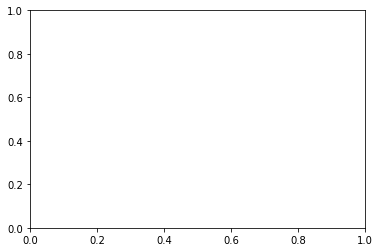

In [29]:
sp.visualise_shapelet()

In [72]:
predicted = sp.predict(time_series,classifier="dtree")
predicted

[1. 2.]


[1.0, 1.0, 2.0, 2.0, 2.0]

In [78]:
predicted1 = sp.predict(time_series,classifier="dtree1")
predicted1

[1. 2.]


[1.0, 1.0, 1.0, 1.0, 1.0]

In [67]:
from sklearn.metrics import accuracy_score
accuracy_score(predicted,labels)
labels

0    2.0
1    2.0
2    1.0
3    1.0
4    2.0
Name: 0, dtype: float64

In [15]:
print("k","accuracy")
for k in range(10):
    predicted = sp.predict(time_series,k+1)
    acc = accuracy_score(predicted,labels)
    print(k,":",acc)

k accuracy
[1. 2.]
0 : 0.48
[1. 2.]
1 : 0.48
[1. 2.]
2 : 0.48
[1. 2.]
3 : 0.48
[1. 2.]
4 : 0.48
[1. 2.]
5 : 0.48
[1. 2.]
6 : 0.48
[1. 2.]
7 : 0.48
[1. 2.]
8 : 0.48
[1. 2.]
9 : 0.48


In [ ]:
len(time_series)

In [ ]:
def generate_candidates(data, max_len=3, min_len=3):
    candidates, cand_len = [], max_len
    while cand_len >= min_len:
        time_series, labels = data.drop('target', axis=1).values, data['target']
        for time_serie, label in zip(time_series,labels):
            for k in range(len(time_serie)-cand_len+1):
                candidates.append((time_serie[k:k+cand_len], label))
        cand_len -= 1
    return pd.DataFrame(candidates)

def manhattan_distance(x, y, min_dist=float('inf')):
    dist = np.sum(dist_manh([x,y],sum_over_features=False))
    if dist >= min_dist: return None
    return dist

def subsequence_distance(time_series, sub_seq):
    if len(sub_seq) < len(time_series):
        min_dist, min_idx = float("inf"), 0
        for i in range(len(time_series)-len(sub_seq)+1):
            dist = manhattan_distance(sub_seq, time_series[i:i+len(sub_seq)], min_dist)
            if dist is not None and dist < min_dist: min_dist, min_idx = dist, i
        return min_dist, min_idx
    else:
        return None, None

def calculate_entropy(probabilities):
    return sum([-prob * np.log(prob)/np.log(2) if prob != 0 else 0 for prob in probabilities])

def calculate_dict_entropy(distances):
    count = {}
    for distance in distances:
        if distance[1] in count:
            count[distance[1]] += 1
        else: 
            count[distance[1]] = 1
    return calculate_entropy(np.divide(list(count.values()), float(sum(list(count.values())))))

def check_candidate(time_series, shapelet):
    distances = {} 
    data, labels = time_series.drop('target', axis=1).values, time_series['target']
    for time_serie,label in zip(data,labels):
        dist, idx = subsequence_distance(time_serie, shapelet)
        if dist is not None:
            distances[dist] = [(time_serie, label)] if dist not in distances else distances[dist].append((time_serie, label))        
    return find_best_split_dist(distances)

def find_best_split_dist(dist_dict):
    distance_values = list(itertools.chain.from_iterable(list(dist_dict.values())))
    prior_entropy = calculate_dict_entropy(distance_values)
    best_distance, max_ig = 0, 0
    best_left, best_right = None, None
    for split_distance in dist_dict:
        split_left = []
        split_right = []
        for distance in dist_dict:
            if distance <= split_distance: 
                split_left.extend(dist_dict[distance])
            else: 
                split_right.extend(dist_dict[distance])
        ig = prior_entropy - (float(len(split_left))/float(len(distance_values))*calculate_dict_entropy(split_left) + float(len(split_right))/float(len(distance_values)) * calculate_dict_entropy(split_right))
        if ig > max_ig: best_distance, max_ig, best_left, best_right = split_distance, ig, split_left, split_right
    return max_ig, best_distance, best_left, best_right



In [ ]:
def find_shapelets_bf(data, max_len=10, min_len=10, plot=True, verbose=True):
    candidates = generate_candidates(data, max_len, min_len)
    bsf_gain, bsf_shapelet = 0, None
    if verbose: candidates_length = len(candidates)
    for idx, candidate in enumerate(candidates.values):
        gain, dist, data_left, data_right = check_candidate(data, candidate[0])
        if verbose: print(idx, '/', candidates_length, ":", gain, dist)
        if gain > bsf_gain:
            bsf_gain, bsf_shapelet = gain, candidate[0]
            if verbose:
                print('Found new best shapelet with gain & dist:', bsf_gain, dist, [x[1] for x in data_left], \
                                                                                   [x[1] for x in data_right])
            if plot:
                plt.plot(bsf_shapelet)
                plt.show()
            plt.show()
    return bsf_shapelet
bsf_shapelet = find_shapelets_bf(df,verbose=False)


In [ ]:
# candidates = generate_candidates(df, 10, 10)
# print(candidates.shape)
# split_candidates = np.array_split(candidates,500)
# split_candidates[0]

In [ ]:
# from multiprocessing.pool import Pool
# from multiprocessing import JoinableQueue as Queue
# import os, sys

# def find_best_shapelet_worker(data,candidates):
#     bsf_gain, bsf_shapelet = 0, None
#     for idx, candidate in enumerate(candidates.values):
#         gain, dist, data_left, data_right = check_candidate(data, candidate[0])
#         if gain > bsf_gain:
#             bsf_gain, bsf_shapelet = gain, candidate[0]
#     return bsf_shapelet,bsf_gain

# def parallel_worker():
#     while True:
#         split_candidate = imageq.get()
#         shapelet,gain = find_best_shapelet_worker(df, split_candidate) 
#         similarq.put( [shapelet, gain] )
#         imageq.task_done()

# similarq = Queue()
# imageq = Queue()
# candidates = generate_candidates(df, 10, 10)
# print("done")
# split_candidates = np.array_split(candidates,500)
# for split_candidate in split_candidates:
#     imageq.put(pd.DataFrame(split_candidate))
#     break

# pool = Pool(5)
# for i in range(5):
#     pool.apply_async(parallel_worker)

# imageq.join()

# print(similarq)


In [ ]:
best_gain, best_shapelet = 0, None
shapelet_dict = {}

def find_best_shapelet_worker(data,candidates):
    global best_gain, best_shapelet,shapelet_dict
    for idx, candidate in enumerate(candidates.values):
        gain, dist, data_left, data_right = check_candidate(data, candidate[0])
        if gain not in shapelet_dict:
            shapelet_dict[gain]=candidate[0]
#         shapelet_dict = sorted(shapelet_dict)[:10]
#         if
#         if gain > best_gain:
#             best_gain, best_shapelet = gain, candidate[0]
            
candidates = generate_candidates(df, 10, 10)
print("done")
split_candidates = np.array_split(candidates,100)
# print(split_candidates[0])
threads = [threading.Thread(target=find_best_shapelet_worker, args=[df,pd.DataFrame(split_candidate),]) for split_candidate in split_candidates]
# threads = [threading.Thread(target=find_best_shapelet_worker, args=[df,pd.DataFrame(split_candidates[0]),])]
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()
print(shapelet_dict)
# print("Shapelet:",best_shapelet)
# print("Information Gain:",best_gain)
# plt.plot(best_shapelet)
# plt.show()

In [ ]:
len(shapelet_dict)

In [ ]:
sorted_shapelet_dict = sorted(shapelet_dict,reverse=True)[:10]
for shapelet in sorted_shapelet_dict:
    print("Shapelet:",shapelet_dict[shapelet])
    print("Information Gain:",shapelet)
    plt.plot(shapelet_dict[shapelet])
    plt.show()

In [ ]:

def wrap_cand(data,max_len=3,min_len=3):
    cand_len =  max_len
    while cand_len >= min_len:
        time_series, labels = data.drop('target', axis=1).values, data['target']
        for time_serie, label in zip(time_series,labels):
            for k in range(len(time_serie)-cand_len+1):
                gen_cand.append((time_serie[k:k+cand_len], label))
        cand_len -= 1
thread_count = 10
split_dfs = np.array_split(df, thread_count)
gen_cand = []
threads = [threading.Thread(target=wrap_cand, args=[pd.DataFrame(split_df),]) for split_df in split_dfs]
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()
candidates = pd.DataFrame(gen_cand, columns=["shapelet","label"])

In [ ]:
for shaplet in candidates.shapelet:
    dist = check_candidate(df,shaplet)
    break

In [ ]:
dist

In [ ]:
calculate_dict_entropy(histogram_values)